In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pyrfume
from pyrfume.pubchem import get_ghs_classification, parse_ghs_classification_for_odor, GHS_CODES
from rickpy import ProgressBar

In [49]:
path = 'odorants/all_cids_properties.csv'
details = pyrfume.load_data(path, usecols=range(5))
details.head()

,Name,MW,SMILES,IUPACName
CID,,,,
4,1-aminopropan-2-ol,75.11,CC(CN)O,1-aminopropan-2-ol
11,"1,2-dichloroethane",98.96,C(CCl)Cl,"1,2-dichloroethane"
47,3-methyl-2-oxovaleric acid,130.14,CCC(C)C(=O)C(=O)O,3-methyl-2-oxopentanoic acid
49,3-methyl-2-oxobutanoic acid,116.11,CC(C)C(=O)C(=O)O,3-methyl-2-oxobutanoic acid
51,2-ketoglutaric acid,146.10,C(CC(=O)O)C(=O)C(=O)O,2-oxopentanedioic acid


### Cramer Toxicity Class Predictions

In [3]:
tox = pyrfume.load_data('odorants/toxTree.csv')
cramer = details.join(tox, on='SMILES')['Cramer Class']
cramer = cramer.apply(lambda x: len(x.split(' ')[-1][:-1]))
cramer.head()

CID
4     1
11    3
47    1
49    1
51    1
Name: Cramer Class, dtype: int64

In [4]:
pyrfume.save_data(cramer.to_frame(), 'odorants/cramer.csv')

In [5]:
embedded_coords = {key: pyrfume.load_data('odorants/%s_umap.pkl' % key) for key in ('snitz', 'haddad')}

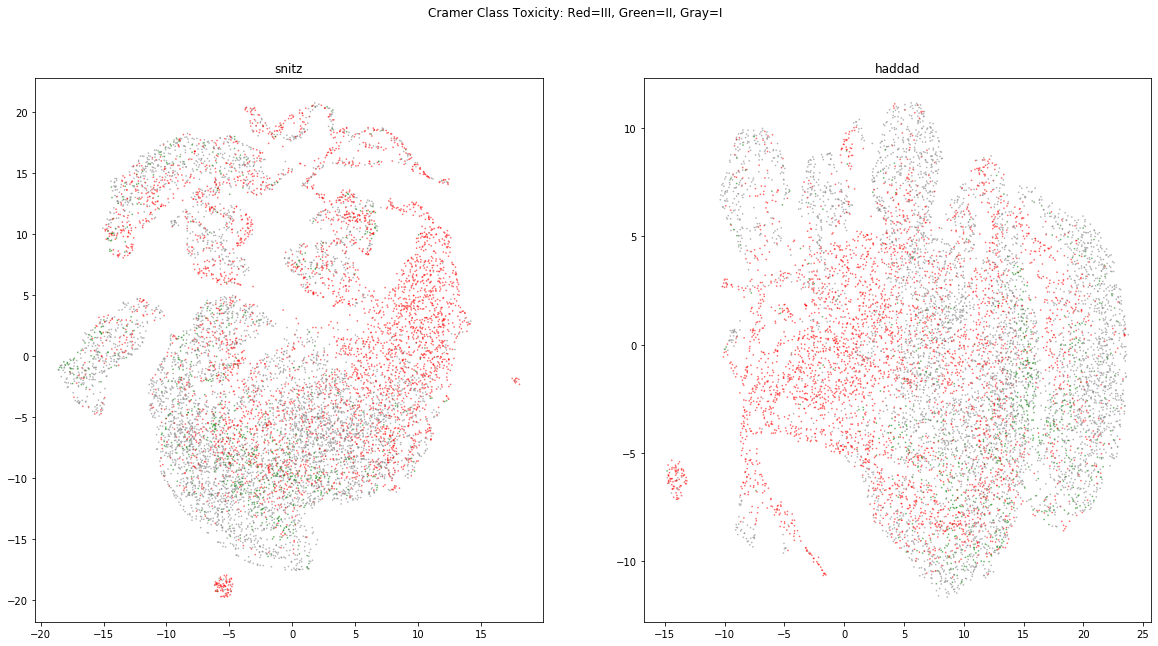

In [6]:
def plot_tox(space, ax):
    coords = embedded_coords[space].join(cramer)
    color_dict = {1:'gray', 2:'green', 3:'red'}
    colors = [color_dict[n] for n in coords['Cramer Class']]
    ax.scatter(*coords[['X', 'Y']].values.T, color=colors, s=0.5, alpha=0.5);
    
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, space in enumerate(('snitz', 'haddad')):
    plot_tox(space, ax[i])
    ax[i].set_title(space)
plt.suptitle('Cramer Class Toxicity: Red=III, Green=II, Gray=I')
plt.savefig('tox.png', dpi=400)

### Empirical Toxicity Information

In [6]:
# Download all toxicity information using PubChem
tox_dict = {}
n_odorants = details.shape[0]
p = ProgressBar(n_odorants)
for i, CID in enumerate(details.index):
    p.animate(i)
    ghs_info = get_ghs_classification(CID)
    strings = parse_ghs_classification_for_odor(ghs_info,
                                                codes=['H330', 'H331', 'H334', 'H340', 'H350', 'H350i', 'H351', 'H36', 'H37'],
                                                only_percent=True,
                                                code_only=True)
    if strings:
        tox_dict[CID] = strings

[-----------------------99%----------------------] 9763 out of 9764 complete

In [9]:
# Reformat into a dataframe
df_tox = pd.DataFrame(columns=['CID', 'Code', '%'])
index = 0
for cid, info in tox_dict.items():
    for x in info:
        code, other = x.split(' ')
        num = float(other[1:-2])
        #print(cid, code, num)
        df_tox.loc[index] = [cid, code, num]
        index += 1
df_tox

,CID,Code,%
0,11,H331,32.10
1,11,H350,100.00
2,177,H351,99.95
3,178,H351,100.00
4,222,H331,99.77
...,...,...,...
685,135398740,H340,10.34
686,135403647,H334,85.71
687,135403647,H334,100.00
688,135403647,H334,100.00


In [56]:
empirical_tox = details.copy()
for key, value in df_tox.groupby(['CID', 'Code']).mean()['%'].items():
    cid, code = key
    empirical_tox.loc[cid, code] = value
empirical_tox = empirical_tox.fillna(0)
empirical_tox.head()

,Name,MW,SMILES,IUPACName,H331,H350,H351,H340,H330,H334,H301+H311+H331,H300+H330,H311+H331,H310+H330,H301+H331,H300+H310+H330
CID,,,,,,,,,,,,,,,,
4,1-aminopropan-2-ol,75.11,CC(CN)O,1-aminopropan-2-ol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,"1,2-dichloroethane",98.96,C(CCl)Cl,"1,2-dichloroethane",32.1,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,3-methyl-2-oxovaleric acid,130.14,CCC(C)C(=O)C(=O)O,3-methyl-2-oxopentanoic acid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,3-methyl-2-oxobutanoic acid,116.11,CC(C)C(=O)C(=O)O,3-methyl-2-oxobutanoic acid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,2-ketoglutaric acid,146.10,C(CC(=O)O)C(=O)C(=O)O,2-oxopentanedioic acid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
pyrfume.save_data(empirical_tox, 'odorants/hcode_tox.csv')